<a href="https://colab.research.google.com/github/Ayesha-Imr/vision-mech-interp/blob/main/ayesha-imr__segment_3_dataset_exemplars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment 03: Dataset Exemplars

## What Are Dataset Exemplars?

In **Segment 02**, we used *activation maximization* to generate synthetic images that maximally activate specific neurons. Those visualizations show us a neuron's "dream image" - the ideal input pattern it's looking for.

But synthetic images don't tell us what **real-world inputs** actually trigger those neurons.

**Dataset exemplars** flip the approach:
- Instead of *generating* images, we *search* through a dataset of real images
- For each neuron, we find the images that produce the highest activation
- These show us what the neuron *actually responds to* in practice

## Why This Matters

| Approach | What It Shows | Limitation |
|----------|--------------|------------|
| Activation Maximization | The "ideal" input pattern | Synthetic, may not exist in real data |
| Dataset Exemplars | What the neuron responds to in practice | Limited to images in the dataset |

Together, they give a much richer picture of what each neuron has learned to detect.

## What We'll Do

1. Stream the **ImageNet validation set** (50,000 images) from HuggingFace
2. Pass each image through **InceptionV1** and capture activations at `mixed4a`
3. For each of the **first 10 channels**, track the **top 10 images** with highest activation
4. Visualize and compare with our Segment 02 results

---
## 1. Setup & Dependencies

In [1]:
# Install required packages
!pip install -q torch-lucent datasets huggingface_hub

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.3 MB/s eta 0:00:00


In [5]:

import torch
import heapq
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from datasets import load_dataset
from lucent.modelzoo import inceptionv1

### HuggingFace Authentication

ImageNet is a gated dataset. You must:
1. Accept the terms at https://huggingface.co/datasets/ILSVRC/imagenet-1k
2. Be logged in to HuggingFace

Run `huggingface-cli login` in your terminal, or use the cell below:

In [2]:
# Option 1: Interactive login (will prompt for token)
from huggingface_hub import login
login()

# Option 2: If already logged in via CLI, this will confirm
# from huggingface_hub import whoami
# try:
#     user_info = whoami()
#     print(f"Logged in as: {user_info['name']}")
# except Exception as e:
#     print("Not logged in! Run: huggingface-cli login")
#     print(f"Error: {e}")

---
## 2. Configuration

In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Layer and channels to analyze
LAYER_NAME = "mixed4a"   # The layer we're studying (middle layer of InceptionV1)
NUM_CHANNELS = 10        # First 10 channels (matching Segment 02)
TOP_K = 10               # Keep top 10 images per channel

# Dataset
DATASET_SPLIT = "validation"  # 50K images
TOTAL_IMAGES = 50_000

print("Configuration:")
print(f"  - Dataset: ImageNet {DATASET_SPLIT} ({TOTAL_IMAGES:,} images)")
print(f"  - Layer: {LAYER_NAME}")
print(f"  - Channels: 0-{NUM_CHANNELS-1}")
print(f"  - Top K images per channel: {TOP_K}")
print(f"  - Estimated time: ~3 minutes")

Configuration:
  - Dataset: ImageNet validation (50,000 images)
  - Layer: mixed4a
  - Channels: 0-9
  - Top K images per channel: 10
  - Estimated time: ~3 minutes


---
## 3. Model Setup

We load **InceptionV1** (also known as GoogLeNet or "inception5h") — the same model used in Segment 02.

This is the original TensorFlow model from 2015, converted to PyTorch. It's commonly used in interpretability research because:
- It has clear, well-studied features
- The Distill article "Feature Visualization" provides reference visualizations
- It's small enough to run quickly but deep enough to be interesting

In [6]:
# Detect available device (GPU is much faster)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained InceptionV1
# - pretrained=True downloads weights trained on ImageNet
# - .eval() puts the model in inference mode (disables dropout, etc.)
model = inceptionv1(pretrained=True).to(device).eval()

print("InceptionV1 loaded successfully")

Using device: cuda
Downloading: "https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth" to /root/.cache/torch/hub/checkpoints/inception5h.pth


100%|██████████| 27.0M/27.0M [00:00<00:00, 295MB/s]


InceptionV1 loaded successfully


### Forward Hook: Capturing Internal Activations

To see what's happening *inside* the network, we use a PyTorch **forward hook**.

**How hooks work:**
1. We register a callback function on a specific layer (`mixed4a`)
2. Every time data flows through that layer, our callback runs
3. The callback saves the layer's output (the "activations") for us to analyze

**About `mixed4a`:**
- It's an "Inception module" — a block that applies multiple filter sizes in parallel
- Output shape: `[batch, 508, H, W]` where 508 = 192 + 204 + 48 + 64 (from 4 branches)
- H and W depend on input image size (for 224x224 input: H=W=14)

In [7]:
# Dictionary to store captured activations
# We use a dict so the hook function can modify it (closures can't reassign outer variables)
activation_storage = {}

def activation_hook(module, input_tensor, output_tensor):
    """
    Forward hook callback.

    This function is called automatically every time the mixed4a layer
    produces output during a forward pass.

    Args:
        module: The layer this hook is attached to (mixed4a)
        input_tensor: The input to this layer (we don't need it)
        output_tensor: The layer's output — this is what we want!
    """
    # Detach from computation graph (we don't need gradients)
    # This saves memory and prevents gradient accumulation
    activation_storage[LAYER_NAME] = output_tensor.detach()

# Register the hook on the mixed4a layer
# model.mixed4a is the Inception module we want to study
hook_handle = model.mixed4a.register_forward_hook(activation_hook)

print(f"Hook registered on '{LAYER_NAME}'")

Hook registered on 'mixed4a'


---
## 4. Data Structures

We use a **min-heap** to efficiently track the top-K images per channel.

**Why a heap?**
- Only stores K images (memory efficient)
- O(log K) to check and update
- Minimum element always on top — easy to compare and replace

---
## 5. ImageNet Validation Set

We use the **validation split** (50,000 images).


**Preprocessing for InceptionV1:**
- Resize smallest edge to 256px, then center crop to 224×224
- Scale pixel values: `pixel * 255 - 117`

In [8]:
# Image preprocessing pipeline
# This transforms PIL images into the format InceptionV1 expects

preprocess_for_model = transforms.Compose([
    transforms.Resize(256),           # Resize so smallest edge is 256px
    transforms.CenterCrop(224),       # Crop center 224x224 region
    transforms.ToTensor(),            # Convert to tensor, scales to [0, 1]
])

def preprocess_image(pil_image):
    """
    Prepare an image for InceptionV1.

    Args:
        pil_image: PIL Image (any size, RGB or other mode)

    Returns:
        Tensor of shape [1, 3, 224, 224] ready for the model
    """
    # Ensure RGB (some ImageNet images are grayscale)
    if pil_image.mode != "RGB":
        pil_image = pil_image.convert("RGB")

    # Apply transforms: resize, crop, convert to [0, 1] tensor
    tensor = preprocess_for_model(pil_image)  # Shape: [3, 224, 224]

    # Scale for InceptionV1: [0, 1] -> [-117, 138]
    # The original TF model was trained with this scaling
    tensor = tensor * 255 - 117

    # Add batch dimension: [3, 224, 224] -> [1, 3, 224, 224]
    return tensor.unsqueeze(0)

In [9]:
# Load ImageNet validation set (streaming - only 50K images)
print("Loading ImageNet validation set (streaming)...")
print("Note: You must have accepted terms at:")
print("  https://huggingface.co/datasets/ILSVRC/imagenet-1k")

imagenet_dataset = load_dataset(
    "ILSVRC/imagenet-1k",
    split=DATASET_SPLIT,
    streaming=True,
)

print(f"Ready! Will process {TOTAL_IMAGES:,} images.")

Loading ImageNet validation set (streaming)...
Note: You must have accepted terms at:
  https://huggingface.co/datasets/ILSVRC/imagenet-1k


README.md:   0%|          | 0.00/87.6k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/294 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/294 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Ready! Will process 50,000 images.


---
## 6. Main Processing Loop

For each image:
1. Preprocess for InceptionV1
2. Forward pass (hook captures activations)
3. Update top-K heaps per channel

In [11]:
# Initialize data structures
# No checkpoint loading needed - we'll process everything in one go

top_images = {ch: [] for ch in range(NUM_CHANNELS)}  # Heaps for top-K per channel
counter = 0  # Tie-breaker for heap

In [12]:
# Process all 50K images
print(f"Processing {TOTAL_IMAGES:,} images...")

pbar = tqdm(imagenet_dataset, total=TOTAL_IMAGES, desc="Processing")

with torch.no_grad():
    for sample in pbar:
        pil_image = sample["image"]

        # Keep original for storage
        original_image = pil_image.copy()
        if original_image.mode != "RGB":
            original_image = original_image.convert("RGB")

        # Preprocess and run model
        model_input = preprocess_image(pil_image).to(device)
        model(model_input)
        acts = activation_storage[LAYER_NAME]

        # Update heaps for each channel
        for ch in range(NUM_CHANNELS):
            activation_value = acts[0, ch].mean().item()
            entry = (activation_value, counter, original_image)
            counter += 1

            if len(top_images[ch]) < TOP_K:
                heapq.heappush(top_images[ch], entry)
            elif activation_value > top_images[ch][0][0]:
                heapq.heapreplace(top_images[ch], entry)

        # Update progress bar
        if counter % 5000 == 0:
            best_act = max(top_images[0])[0] if top_images[0] else 0
            pbar.set_postfix({"ch0_best": f"{best_act:.2f}"})

print("\n✓ Done! Found top-10 images for each channel.")

Processing 50,000 images...


Processing:   0%|          | 0/50000 [00:00<?, ?it/s]


✓ Done! Found top-10 images for each channel.


---
## 7. Results Visualization

Now let's see what we found! For each channel, we display the 10 ImageNet images that produced the highest activation.

**How to interpret these results:**
- Look for **common themes** across the top images for each channel
- Compare with the **activation maximization** images from Segment 02
- Some channels will be clearly interpretable; others may be more mysterious

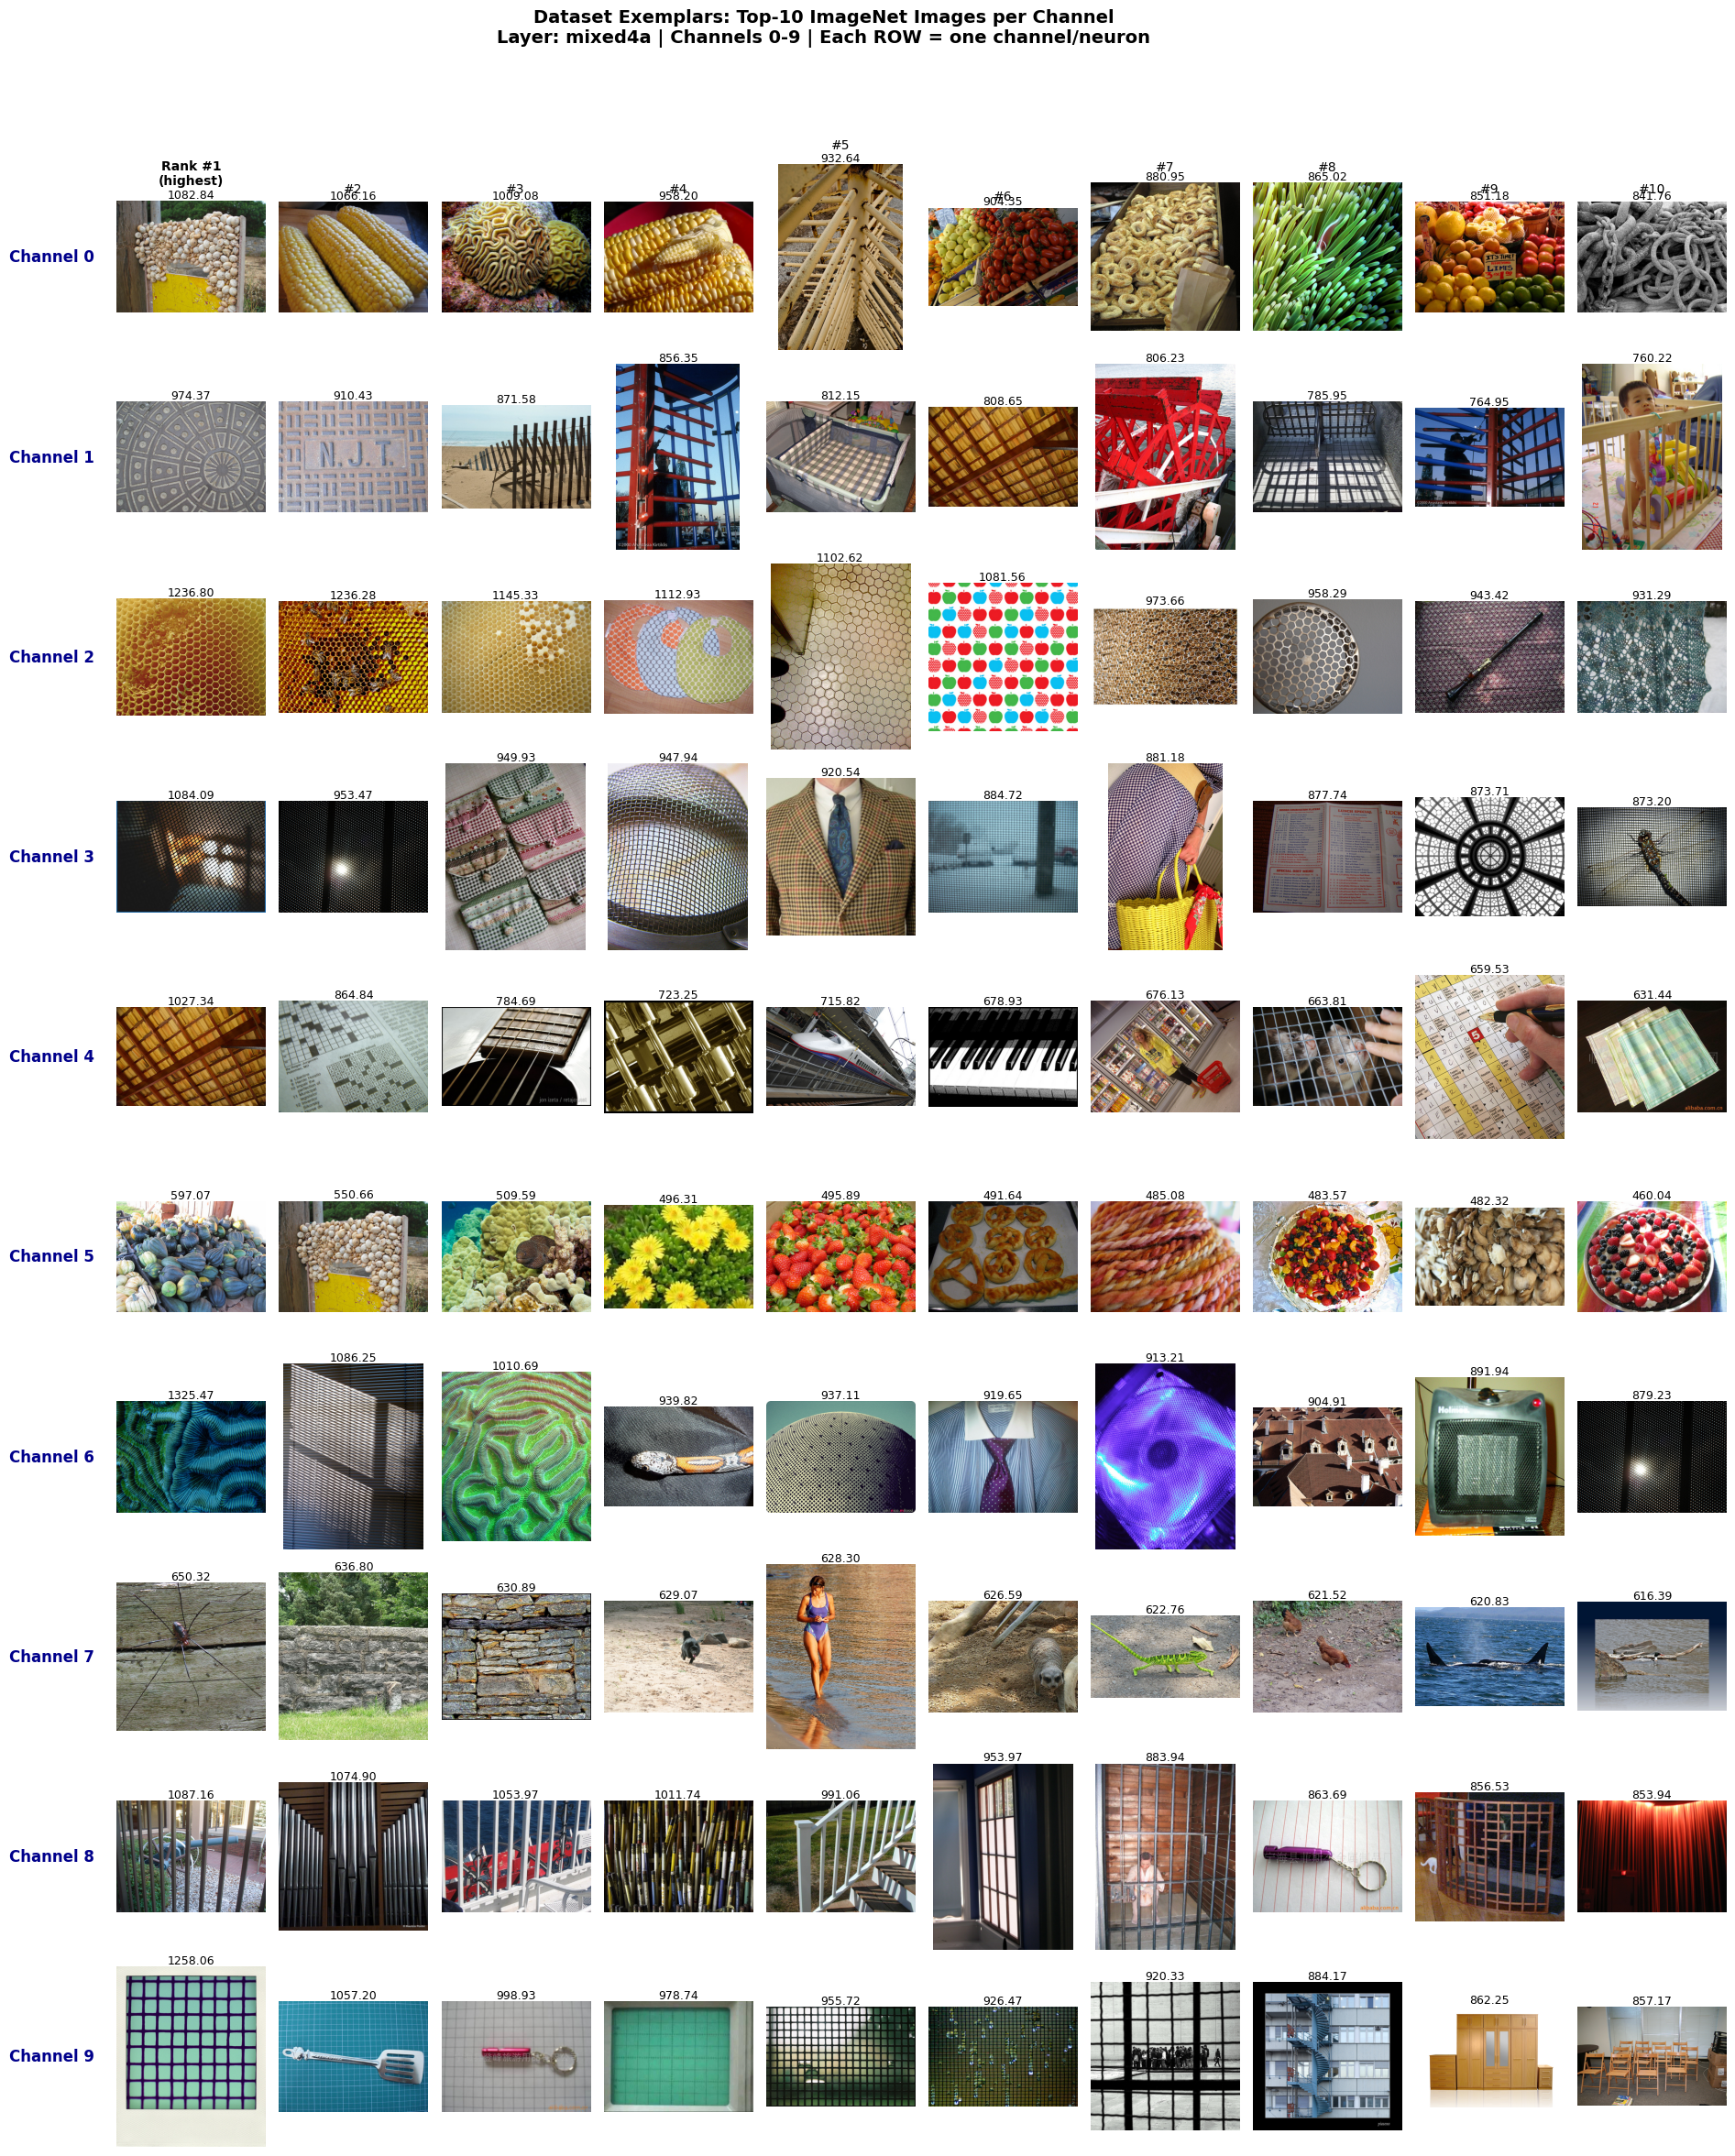

In [15]:
# Create visualization grid with CLEAR labels
fig, axes = plt.subplots(NUM_CHANNELS, TOP_K, figsize=(20, 24))

# Add space on the left for channel labels
plt.subplots_adjust(left=0.08, top=0.92, bottom=0.02)

for ch in range(NUM_CHANNELS):
    # Sort heap by activation (highest first)
    ranked = sorted(top_images[ch], key=lambda x: x[0], reverse=True)

    for rank, (activation_value, _, pil_image) in enumerate(ranked):
        ax = axes[ch][rank]
        ax.imshow(pil_image)
        ax.axis("off")

        # Activation value below each image
        ax.set_title(f"{activation_value:.2f}", fontsize=9, pad=2)

        # Column headers (rank) - only on first row
        if ch == 0:
            if rank == 0:
                ax.annotate(
                    f"Rank #1\n(highest)",
                    xy=(0.5, 1.15),
                    xycoords="axes fraction",
                    ha="center",
                    fontsize=10,
                    fontweight="bold",
                )
            else:
                ax.annotate(
                    f"#{rank+1}",
                    xy=(0.5, 1.08),
                    xycoords="axes fraction",
                    ha="center",
                    fontsize=10,
                )

    # Row labels (channel) - on the left side, outside the plot
    axes[ch][0].annotate(
        f"Channel {ch}",
        xy=(-0.15, 0.5),
        xycoords="axes fraction",
        ha="right",
        va="center",
        fontsize=12,
        fontweight="bold",
        color="darkblue",
    )

# Main title
fig.suptitle(
    f"Dataset Exemplars: Top-10 ImageNet Images per Channel\n"
    f"Layer: {LAYER_NAME} | Channels 0-{NUM_CHANNELS-1} | Each ROW = one channel/neuron",
    fontsize=14,
    fontweight="bold",
    y=0.98,
)

plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.show()


---
## 9. Cleanup

In [17]:
# Remove the forward hook to clean up
hook_handle.remove()

# Clear activation storage
activation_storage.clear()